In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

from collections import Counter

# Load in all the Data

In [171]:
with open('ei_intermediate_file_paths.json') as file_path_file:
    file_paths = json.load(file_path_file)


SI_HISTORICAL_INPUT_PATH = file_paths.get("historical_si_per_year_csv")

NOAA_BLS_MERGED_INPUT_PATH = file_paths.get("stage2_fs_merged_output.csv")

EI_MODEL_OUTPUT_PATH = file_paths.get("ei_model_output")

In [172]:
# Load dataset
si_historical_df = pd.read_csv(SI_HISTORICAL_INPUT_PATH)

noaa_bls_df = pd.read_csv(NOAA_BLS_MERGED_INPUT_PATH)

## Review the Smoke Impact Data

In [173]:
print(si_historical_df.head(5))

   year  fire_year  total_amortized_smoke_impact  total_fire_duration  \
0  1961        NaN                           NaN                  NaN   
1  1962        NaN                           NaN                  NaN   
2  1963        NaN                           NaN                  NaN   
3  1964     1964.0                  7.432192e-07            10.002545   
4  1965     1965.0                  1.181915e-06            30.003913   

   total_acres_burned  avg_daily_smoke_impact  scaled_avg_daily_smoke_impact  
0                 NaN                     NaN                            NaN  
1                 NaN                     NaN                            NaN  
2                 NaN                     NaN                            NaN  
3           28.468121            7.430301e-08                        0.74303  
4           43.781494            3.939202e-08                        0.39392  


In [174]:
# List all column names
columns = si_historical_df.columns
print("Column names:\n", columns)

# Check data types of each column
data_types = si_historical_df.dtypes
print("Data types of columns:\n", data_types)

# Find out the number of rows in the dataset
num_rows = len(si_historical_df)
print("Number of rows:", num_rows)

Column names:
 Index(['year', 'fire_year', 'total_amortized_smoke_impact',
       'total_fire_duration', 'total_acres_burned', 'avg_daily_smoke_impact',
       'scaled_avg_daily_smoke_impact'],
      dtype='object')
Data types of columns:
 year                               int64
fire_year                        float64
total_amortized_smoke_impact     float64
total_fire_duration              float64
total_acres_burned               float64
avg_daily_smoke_impact           float64
scaled_avg_daily_smoke_impact    float64
dtype: object
Number of rows: 61


## Review the BLS and NOAA Data

In [175]:
print(noaa_bls_df.head(5))

         date    bls_date  bls_curr_sae_hrs  bls_curr_laus_labor_force  \
0  2009-09-01  2009-09-01              36.8                   421301.0   
1  2009-10-01  2009-10-01              36.7                   422913.0   
2  2010-05-01  2010-05-01              38.0                   415895.0   
3  2010-06-01  2010-06-01              37.9                   421034.0   
4  2010-07-01  2010-07-01              37.4                   423239.0   

   bls_curr_laus_unemployment_rate  bls_prev_yr_sae_hrs  \
0                              9.1                 37.4   
1                              8.8                 37.0   
2                              8.2                 37.4   
3                              8.7                 37.9   
4                              8.4                 37.1   

   bls_prev_yr_laus_labor_force  bls_prev_yr_laus_unemployment_rate  \
0                      427171.0                                 5.8   
1                      431740.0                           

In [176]:
# List all column names
noaa_bls_columns = noaa_bls_df.columns
print("Column names:\n", noaa_bls_columns)

# Check data types of each column
noaa_bls_data_types = noaa_bls_df.dtypes
print("Data types of columns:\n", noaa_bls_data_types)

# Find out the number of rows in the dataset
noaa_bls_num_rows = len(noaa_bls_df)
print("Number of rows:", noaa_bls_num_rows)

Column names:
 Index(['date', 'bls_date', 'bls_curr_sae_hrs', 'bls_curr_laus_labor_force',
       'bls_curr_laus_unemployment_rate', 'bls_prev_yr_sae_hrs',
       'bls_prev_yr_laus_labor_force', 'bls_prev_yr_laus_unemployment_rate',
       'bls_pct_diff_sae_hrs', 'bls_pct_diff_laus_labor_force',
       'bls_pct_diff_laus_unemployment_rate', 'noaa_name', 'noaa_date',
       'noaa_tavg', 'noaa_tmax', 'noaa_tmin', 'noaa_prcp'],
      dtype='object')
Data types of columns:
 date                                    object
bls_date                                object
bls_curr_sae_hrs                       float64
bls_curr_laus_labor_force              float64
bls_curr_laus_unemployment_rate        float64
bls_prev_yr_sae_hrs                    float64
bls_prev_yr_laus_labor_force           float64
bls_prev_yr_laus_unemployment_rate     float64
bls_pct_diff_sae_hrs                   float64
bls_pct_diff_laus_labor_force          float64
bls_pct_diff_laus_unemployment_rate    float64
noaa_nam

## Merge the Data

In [177]:
# Ensure the date columns are in datetime format for NOAA/BLS dataset
noaa_bls_df['date'] = pd.to_datetime(noaa_bls_df['date'])

# Repeat the 'scaled_avg_daily_smoke_impact' value for each month in the year
# Create a new 'year' column in NOAA/BLS dataset to merge with SI historical data
noaa_bls_df['year'] = noaa_bls_df['date'].dt.year

In [178]:
merged_df = pd.merge(
    noaa_bls_df[['date', 'year', 'noaa_tavg', 'noaa_prcp', 'bls_pct_diff_sae_hrs', 'bls_pct_diff_laus_labor_force', 'bls_pct_diff_laus_unemployment_rate']],
    si_historical_df[['year', 'scaled_avg_daily_smoke_impact']],
    on='year',
    how='left'
)

# Drop the 'year' column as it's no longer needed
merged_df = merged_df.drop(columns=['year'])



In [179]:
# Display the merged dataset
print(merged_df.head(18))

         date  noaa_tavg  noaa_prcp  bls_pct_diff_sae_hrs  \
0  2009-09-01       75.7       8.60             -1.604278   
1  2009-10-01       60.7      10.55             -0.810811   
2  2010-05-01       74.2       9.26              1.604278   
3  2010-06-01       84.6       0.31              0.000000   
4  2010-07-01       84.9       6.30              0.808625   
5  2010-08-01       86.6       2.32             -0.534759   
6  2010-09-01       79.2       0.15              0.000000   
7  2010-10-01       66.1       2.04              0.544959   
8  2011-05-01       70.2       7.12             -1.578947   
9  2011-06-01       83.7       3.56             -1.583113   
10 2011-07-01       86.0       2.95             -1.604278   
11 2011-08-01       83.9       3.08             -0.268817   
12 2011-09-01       73.3       2.56              0.543478   
13 2011-10-01       62.7       1.28              0.813008   
14 2012-05-01       76.3       3.18             -2.673797   
15 2012-06-01       80.2

## Training

In [180]:
# Identify rows in the merged dataset with missing values
nan_rows = merged_df[merged_df[['scaled_avg_daily_smoke_impact', 'noaa_tavg', 'noaa_prcp', 'bls_pct_diff_laus_unemployment_rate']].isna().any(axis=1)]

# Display the rows with NaN values
print("Rows with NaN values:\n", nan_rows)

# Alternatively, you can save these rows to a CSV for further review
# nan_rows.to_csv('nan_rows_review.csv', index=False)


Rows with NaN values:
          date  noaa_tavg  noaa_prcp  bls_pct_diff_sae_hrs  \
68 2021-05-01       69.5       4.01              5.027933   
69 2021-06-01       78.9       4.74              2.185792   
70 2021-07-01       81.6       5.73              1.639344   
71 2021-08-01       83.0       2.40              0.539084   
72 2021-09-01       75.9       2.04             -0.546448   
73 2021-10-01       67.9       4.78             -1.355014   
74 2022-05-01       74.3       4.05             -1.063830   
75 2022-06-01       83.2       0.88             -0.802139   
76 2022-07-01       87.2       4.24             -1.344086   
77 2022-08-01       82.9       5.95              0.000000   
78 2022-09-01       77.7       2.24              1.648352   
79 2022-10-01       63.2       4.82              1.648352   
80 2023-05-01       72.6       2.05             -2.419355   
81 2023-06-01       79.4       5.41             -1.347709   
82 2023-07-01       82.3       8.62             -0.272480   
8

In [181]:
num_rows_before_remove_nan = len(merged_df)
print(f'Number of rows before removing nan: {num_rows_before_remove_nan}')

# Drop rows with any NaN values in X or y
merged_df = merged_df.dropna(subset=['scaled_avg_daily_smoke_impact', 'noaa_tavg', 'noaa_prcp', 'bls_pct_diff_laus_unemployment_rate'])

num_rows_after_remove_nan = len(merged_df)
print(f'Number of rows before removing nan: {num_rows_after_remove_nan}')

# Summary statistics to understand the dataset better (excluding the DATE column)
summary_stats = merged_df.describe()
print("Summary statistics:\n", summary_stats)

Number of rows before removing nan: 91
Number of rows before removing nan: 68
Summary statistics:
                                 date  noaa_tavg  noaa_prcp  \
count                             68  68.000000  68.000000   
mean   2015-05-15 09:10:35.294117632  76.598529   4.308382   
min              2009-09-01 00:00:00  60.700000   0.120000   
25%              2012-07-24 06:00:00  71.225000   2.152500   
50%              2015-06-16 00:00:00  78.400000   3.695000   
75%              2018-05-08 18:00:00  82.275000   5.320000   
max              2020-10-01 00:00:00  86.600000  13.400000   
std                              NaN   7.079938   2.958250   

       bls_pct_diff_sae_hrs  bls_pct_diff_laus_labor_force  \
count             68.000000                      68.000000   
mean              -0.167823                      -0.035703   
min               -4.210526                      -3.787130   
25%               -1.092164                      -1.462664   
50%               -0.134409     

## Grid Search & Bootstrapping - Find Most Common Best Parameters Across Bootstraps

In [ ]:
# Set up fixed random state
fixed_random_state = 42

# Define the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=fixed_random_state)

# Set up the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

# Bootstrapping with Grid Search in each iteration
n_iterations = 100  # Number of bootstrap samples
boot_mse_scores = []
boot_r2_scores = []
boot_best_params = []  # To store best parameters from each iteration

# Variables to track the best model and its performance
best_overall_model = None
best_overall_r2 = -np.inf  # Initialize to negative infinity
best_overall_params = None

for i in range(n_iterations):
    # Resample with replacement to create a bootstrap sample
    X_resample, y_resample = resample(X, y, replace=True, random_state=fixed_random_state + i)
    
    # Split the resampled dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.2, random_state=fixed_random_state)
    
    # Perform Grid Search on the bootstrap sample
    grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Get the best model and hyperparameters
    best_gbr = grid_search.best_estimator_
    best_params = grid_search.best_params_
    boot_best_params.append(best_params)
    
    # Evaluate the best model on the test set
    y_pred = best_gbr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the evaluation metrics
    boot_mse_scores.append(mse)
    boot_r2_scores.append(r2)
    
    # Update the best overall model if the current one is better
    if r2 > best_overall_r2:
        best_overall_r2 = r2
        best_overall_model = best_gbr
        best_overall_params = best_params




print("Best overall R^2 Score:", best_overall_r2)
print("Best overall hyperparameters:", best_overall_params)

# Summary Statistics
print("Average Bootstrap Mean Squared Error:", np.mean(boot_mse_scores))
print("Average Bootstrap R^2 Score:", np.mean(boot_r2_scores))

# Analyze the best hyperparameters across bootstrap iterations

param_counts = Counter(tuple(p.items()) for p in boot_best_params)
most_common_params = param_counts.most_common(1)[0][0]
most_common_params = dict(most_common_params)  # Convert back to dictionary
print("Most Common Best Parameters Across Bootstraps:", most_common_params)

Best overall model saved to best_gradient_boosting_model.pkl
Best overall R^2 Score: 0.9993707476415556
Best overall hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Average Bootstrap Mean Squared Error: 431.5041469725602
Average Bootstrap R^2 Score: 0.48444340639522315
Most Common Best Parameters Across Bootstraps: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}


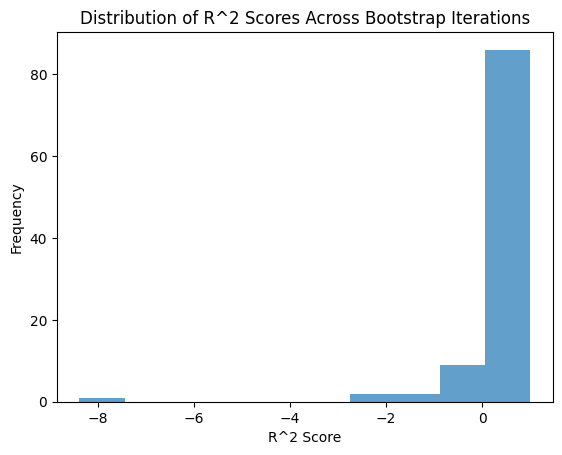

In [192]:
plt.hist(boot_r2_scores, bins=10, alpha=0.7)
plt.title('Distribution of R^2 Scores Across Bootstrap Iterations')
plt.xlabel('R^2 Score')
plt.ylabel('Frequency')
plt.show()

## Grid Search & Bootstrapping - Find Most Common Best Parameters Across Bootstraps

In [209]:
# Use the most common best parameters from the previous bootstrap
fixed_params = {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
best_gbr_fixed = GradientBoostingRegressor(**fixed_params, random_state=fixed_random_state)

# Perform Bootstrapping Without Grid Search
n_iterations = 100  # Number of bootstrap samples
boot_mse_scores_fixed = []
boot_r2_scores_fixed = []

for i in range(n_iterations):
    # Resample with replacement to create a bootstrap sample
    X_resample, y_resample = resample(X, y, replace=True, random_state=fixed_random_state + i)
    
    # Split the resampled dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resample, y_resample, test_size=0.3, random_state=fixed_random_state)
    
    # Train the model with fixed hyperparameters
    best_gbr_fixed.fit(X_train, y_train)
    
    # Evaluate the model on the test set
    y_pred = best_gbr_fixed.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the evaluation metrics
    boot_mse_scores_fixed.append(mse)
    boot_r2_scores_fixed.append(r2)

# Summary Statistics for Fixed Hyperparameters
print("Average Bootstrap Mean Squared Error (Fixed Params):", np.mean(boot_mse_scores_fixed))
print("Average Bootstrap R^2 Score (Fixed Params):", np.mean(boot_r2_scores_fixed))

Average Bootstrap Mean Squared Error (Fixed Params): 374.3102390048586
Average Bootstrap R^2 Score (Fixed Params): 0.7007845449252588


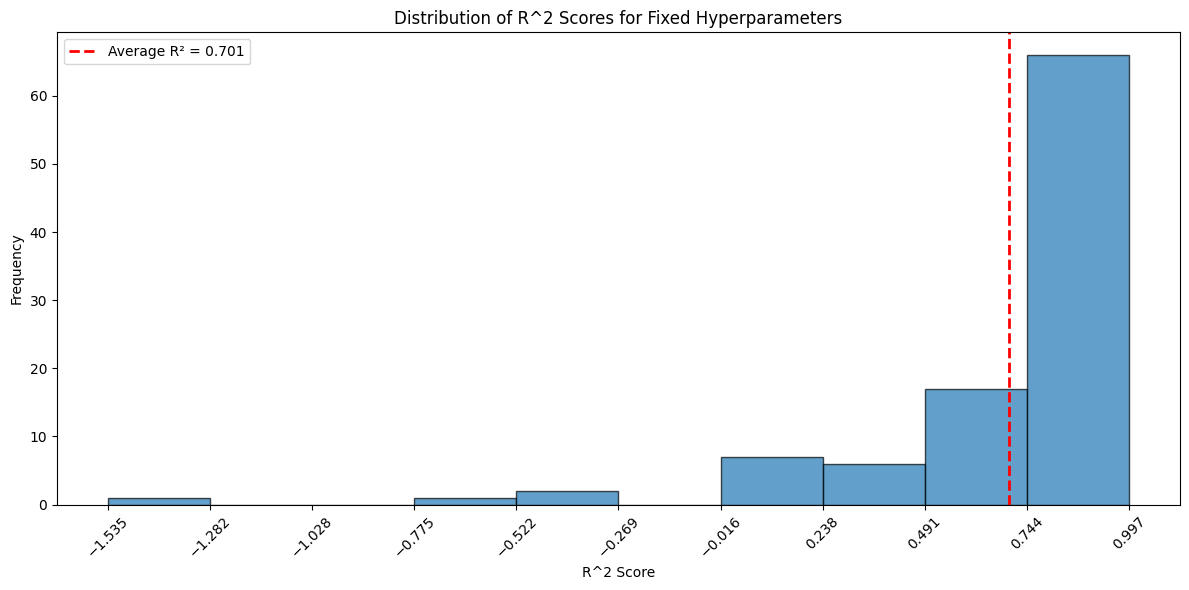

In [212]:
# Calculate the average R² score
average_r2 = np.mean(boot_r2_scores_fixed)

# Create histogram with 20 bins
bins = np.linspace(min(boot_r2_scores_fixed), max(boot_r2_scores_fixed), 11)  # 21 edges for 20 bins
hist, edges = np.histogram(boot_r2_scores_fixed, bins=bins)

# Plot histogram
plt.figure(figsize=(12, 6))  # Make the chart wider
plt.bar(edges[:-1], hist, width=np.diff(edges), align='edge', alpha=0.7, edgecolor='black')

# Add a vertical line for the average value
plt.axvline(average_r2, color='red', linestyle='--', linewidth=2, label=f'Average R² = {average_r2:.3f}')

# Set titles and labels
plt.title('Distribution of R^2 Scores for Fixed Hyperparameters')
plt.xlabel('R^2 Score')
plt.ylabel('Frequency')

# Set x-axis tick labels for each bin
plt.xticks(edges, rotation=45)

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()



In [186]:
# Save the model to a file
with open(EI_MODEL_OUTPUT_PATH, 'wb') as file:
    pickle.dump(best_gbr_fixed, file)